In [ ]:
from utils import *

# Vectorization Solutions

In [ ]:
import jax.numpy as jnp
import chex

## Array Operations

In [ ]:
def array_operations_q1(N):
    return jnp.sum(jnp.log(jnp.arange(N) + 1.0))

print(array_operations_q1(10.0))
print(array_operations_q1(20.0))

In [ ]:
def array_operations_q2(N, M):
    i = jnp.tile(jnp.arange(N)[..., None], M)
    j = jnp.tile(jnp.arange(M)[..., None], N).T

    return jnp.sum(jnp.log(i * j + 1.0))

print(array_operations_q2(5, 10))
print(array_operations_q2(30, 20))

## Slicing

In [ ]:
def array_slicing_q1(a):
    return a[1:] - a[:-1]

array_slicing_q1(jnp.array([0.0, 1.0, 5.0, 10.0, 20.0]))

In [ ]:
def array_slicing_q2(a):
    return a[..., 1:] - a[..., :-1]

array_slicing_q2(jnp.array([
    [0.0, 1.0, 5.0, 10.0, 20.0],
    [2.0, 5.0, 6.0, 20.0, 30.0]
]))

## Indexing with Boolean Arrays

In [ ]:
def boolean_indexing_q1(a):
    chex.assert_rank(a, 2)    
    positive_sum = a.sum(axis=-1) > 0.0
    return a[positive_sum]

boolean_indexing_q1(jnp.array([
    [1.0, 2.0, 3.0],
    [-1.0, -2.0, 3.0],
    [-1.0, -2.0, 4.0],
    [-1.0, -2.0, -3.0],
]))

In [ ]:
def boolean_indexing_q2(N, x, y, r):
    assert(0 < N)
    assert(0 <= x and x < N)
    assert(0 <= y and y < N)
    assert(0 < r)
    
    rows = jnp.tile(jnp.arange(N)[..., None], N)
    cols = rows.T
    result = ((rows - x) ** 2.0 + (cols - y) ** 2.0 <= r ** 2.0).astype('int32')

    chex.assert_shape(result, (N, N))
    return result

print(boolean_indexing_q2(10, 3, 4, 2))
print('')
print(boolean_indexing_q2(10, 9, 8, 2))

## Indexing with Arrays of Indices

In [ ]:
def integer_indexing_q1(a):
    chex.assert_rank(a, 2)
    chex.assert_size(a, a.shape[0] ** 2)
    
    i = jnp.arange(a.shape[0])
    result = a[(i, i)]

    chex.assert_shape(result, (a.shape[0],))
    return result

a = jnp.arange(6 * 6).reshape(6, 6)
print(a)
print('')
print(integer_indexing_q1(a))

In [ ]:
def integer_indexing_q2(a, offset=0):
    chex.assert_rank(a, 2)
    chex.assert_size(a, a.shape[0] ** 2)
    
    i = jnp.arange(a.shape[0] - abs(offset)) - offset * (offset <= 0)
    j = jnp.arange(a.shape[1] - abs(offset)) + offset * (offset > 0)
    result = a[(i, j)]

    chex.assert_shape(result, (a.shape[0] - abs(offset),))
    return result

a = jnp.arange(6 * 6).reshape(6, 6)
print(a)
print('')

for offset in [-2, -1, 0, 1, 2]:
    print(f'Offset {offset}:', integer_indexing_q2(a, offset=offset))

## Broadcasting

In [ ]:
def broadcasting_q1(a, b):
    chex.assert_rank((a, b), 2)
    chex.assert_equal_shape_suffix((a, b), 1)
    
    result = jnp.sum((b[None, ...] - a[:, None, ...]) ** 2.0, axis=-1)

    chex.assert_shape(result, (a.shape[0], b.shape[0]))
    return result

a = jnp.array([
    [1, 2],
    [2, 4],
    [5, 6],
])

b = jnp.array([
    [5, 3],
    [4, 1],
    [6, 6],
    [7, 1],
])

broadcasting_q1(a, b)

## Regression Solutions

In [ ]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax.numpy as jnp
import jax.random as jrandom
import numpyro.distributions.constraints as C
from cs349 import *

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-CTR-CGLF-regression-augmented.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of patients, just to see what's in the data
data.sample(15, random_state=0)

In [ ]:
def model_polynomial_regressor(N, x, y=None, degree=1):
    coefficients = numpyro.param(
        'coefficients',
        jnp.ones(degree + 1),
        constraint=C.real,
    )

    std_dev = numpyro.param(
        'std_dev',
        jnp.array(1.0),
        constraint=C.positive,
    )

    with numpyro.plate('data', N):
        mu = jnp.polyval(coefficients, x)
        p_y_given_x = D.Normal(mu, std_dev)
        numpyro.sample('y', p_y_given_x, obs=y)

In [ ]:
NUM_ITERATIONS = 10000
DEGREE = 8

# Define an optimizer; here we chose the "Adam" algorithm
optimizer = numpyro.optim.Adam(step_size=0.01)

# Pick a random generator seed for the optimizer
key_optimizer = jrandom.PRNGKey(seed=0)

result = cs349_mle(
    model_polynomial_regressor, 
    optimizer, 
    key_optimizer, 
    NUM_ITERATIONS,
    len(data), 
    jnp.array(data['Glow']), 
    y=jnp.array(data['Telekinetic-Ability']),
    degree=DEGREE,
)

In [ ]:
plt.scatter(jnp.arange(NUM_ITERATIONS), result.losses)
plt.xlabel('Optimization Step')
plt.ylabel('Loss')
plt.title('Convergence of MLE')
plt.show()

In [ ]:
test_x = jnp.linspace(0.0, 1.3, 100)

S = 10
samples = cs349_sample_generative_process(
    result.model_mle, 
    jrandom.PRNGKey(seed=0), 
    len(test_x), 
    test_x,
    degree=DEGREE,
    num_samples=S,
)

plt.scatter(
    test_x[None, ...].repeat(S, axis=0).flatten(), 
    samples['y'].flatten(), 
    color='blue', 
    alpha=0.5,
    label='Samples',
)
plt.scatter(data['Glow'], data['Telekinetic-Ability'], color='red', alpha=0.5, label='Data')

plt.xlabel('Glow')
plt.ylabel('Telekinetic Ability')
plt.title('Telekinetic Ability vs. Glow')

plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

axes[0, 0].hist(data['Age'], bins=50, density=True)
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Probability from Data')
axes[0, 0].set_title('Distribution of Ages')

axes[0, 1].scatter(data['Age'], data['Glow'], alpha=0.5, color='red')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Glow')
axes[0, 1].set_title('Glow vs. Age')

axes[1, 0].scatter(data['Age'], data['Telekinetic-Ability'], alpha=0.5, color='red')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Telekinetic-Ability')
axes[1, 0].set_title('Telekinetic-Ability vs. Age')

axes[1, 1].scatter(data['Glow'], data['Telekinetic-Ability'], alpha=0.5, color='red')
axes[1, 1].set_xlabel('Glow')
axes[1, 1].set_ylabel('Telekinetic-Ability')
axes[1, 1].set_title('Telekinetic-Ability vs. Glow')

plt.tight_layout()
plt.show()

## Classification Solutions

In [ ]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax.numpy as jnp
import jax.random as jrandom
import jax.nn as jnn
import numpyro
import numpyro.distributions as D
import numpyro.distributions.constraints as C
from cs349 import *

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-CTR-CGLF-classification.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of patients, just to see what's in the data
data.sample(15, random_state=0)

In [ ]:
def model_nonlinear_classifier(N, age, dose, control=None):
    degree = 8
    
    coefficients_age = numpyro.param(
        'coefficients_age',
        jnp.ones(degree + 1) * 0.1,
        constraint=C.real,
    )

    coefficients_dose = numpyro.param(
        'coefficients_dose',
        jnp.ones(degree + 1) * 0.1,
        constraint=C.real,
    )

    with numpyro.plate('data', N):
        rho = jnn.sigmoid(
            jnp.polyval(coefficients_age, age / 100.0) 
            + jnp.polyval(coefficients_dose, dose)
        )
        p_y_given_x = D.Bernoulli(rho)
        numpyro.sample('control', p_y_given_x, obs=control)

In [ ]:
NUM_ITERATIONS = 200000

# Define an optimizer; here we chose the "Adam" algorithm
optimizer = numpyro.optim.Adam(step_size=0.01)

# Pick a random generator seed for the optimizer
key_optimizer = jrandom.PRNGKey(seed=0)

result = cs349_mle(
    model_nonlinear_classifier, 
    optimizer, 
    key_optimizer, 
    NUM_ITERATIONS,
    len(data), 
    jnp.array(data['Age']),
    jnp.array(data['Dose']),
    control=jnp.array(data['Control-After']),
)

In [ ]:
plt.scatter(jnp.arange(NUM_ITERATIONS), result.losses)
plt.xlabel('Optimization Step')
plt.ylabel('Loss')
plt.title('Convergence of MLE')
plt.show()

In [ ]:
plot_classifier_of_control_vs_age_and_dose(
    data, result.model_mle, 'control',
)

## Neural Networks

In [ ]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax.numpy as jnp
import jax.random as jrandom
import jax.nn as jnn
import numpyro
import numpyro.distributions as D
import numpyro.distributions.constraints as C
from cs349 import *

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-CTR-CGLF-regression-augmented.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of patients, just to see what's in the data
data.sample(15, random_state=0)

In [ ]:
def model_neural_network_regressor(N, x, y=None, H=20):
    W0 = numpyro.param(
        'W0',
        lambda key: 0.1 * jrandom.normal(key, shape=(1, H)),
        constraint=C.real,
    )

    b0 = numpyro.param(
        'b0',
        lambda key: 0.1 * jrandom.normal(key, shape=(H,)),
        constraint=C.real,
    )

    W1 = numpyro.param(
        'W1',
        lambda key: 0.1 * jrandom.normal(key, shape=(H, 1)),
        constraint=C.real,
    )

    b1 = numpyro.param(
        'b1',
        lambda key: 0.1 * jrandom.normal(key, shape=(1,)),
        constraint=C.real,
    )

    std_dev = numpyro.param(
        'std_dev',
        jnp.array([1.0]),
        constraint=C.positive,
    )

    with numpyro.plate('data', N, dim=-2):
        inner = jnn.sigmoid(jnp.matmul(x, W0) + b0)
        outer = jnp.matmul(inner, W1) + b1
        
        p_y_given_x = D.Normal(outer, std_dev)
        numpyro.sample('y', p_y_given_x, obs=y)

In [ ]:
NUM_ITERATIONS = 100000
H = 50

# Define an optimizer; here we chose the "Adam" algorithm
optimizer = numpyro.optim.Adam(step_size=0.01)

# Pick a random generator seed for the optimizer
key_optimizer = jrandom.PRNGKey(seed=0)

result = cs349_mle(
    model_neural_network_regressor, 
    optimizer, 
    key_optimizer, 
    NUM_ITERATIONS,
    len(data), 
    jnp.array(data['Age']).reshape(-1, 1), 
    y=jnp.array(data['Telekinetic-Ability']).reshape(-1, 1),
    H=H,
)

plt.scatter(jnp.arange(NUM_ITERATIONS), result.losses)
plt.xlabel('Optimization Step')
plt.ylabel('Loss')
plt.title('Convergence of MLE')
plt.show()

In [ ]:
test_x = jnp.linspace(0.0, 100, 200)

S = 10
samples = cs349_sample_generative_process(
    result.model_mle, 
    jrandom.PRNGKey(seed=0), 
    len(test_x),  
    test_x.reshape(-1, 1),
    H=H,
    num_samples=S,
)

plt.scatter(
    test_x[None, ...].repeat(S, axis=0).flatten(), 
    samples['y'].flatten(), 
    color='blue', 
    alpha=0.5,
    label='Samples',
)
plt.scatter(data['Age'], data['Telekinetic-Ability'], color='red', alpha=0.5, label='Data')

plt.xlabel('Age')
plt.ylabel('Telekinetic Ability')
plt.title('Telekinetic Ability vs. Age')

plt.legend()
plt.show()

## Dimensionality Reduction (VAE)

In [1]:
import jax.nn as jnn

from utils import *
from cs349 import *

In [2]:
data = jnp.load('data/microscope.npy')

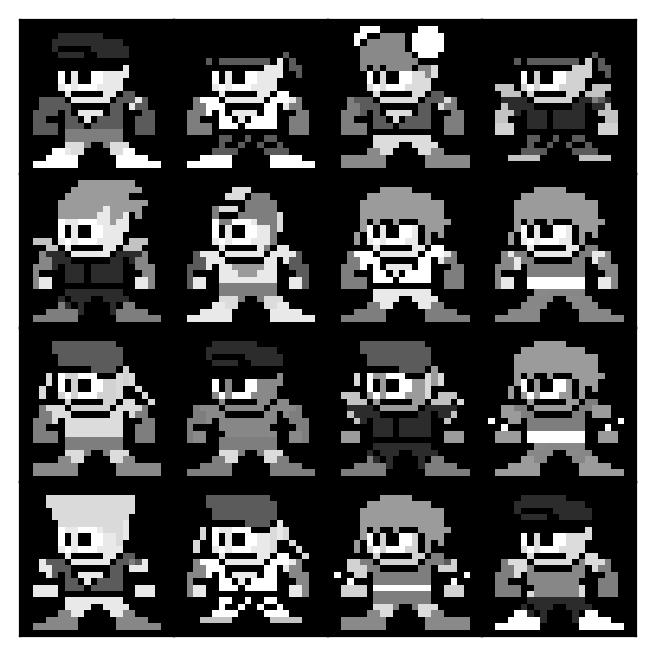

In [3]:
visualize_microscope_samples(data[:16])

In [41]:
def microscope_generative_model(N, x=None, layers=[2, 400, 24 * 24]):
    decoder_fn = neural_network_fn('decoder', N, layers)

    '''
    std_dev = numpyro.param(
        'std_dev',
        jnp.array(0.01),
        constraint=C.positive,
    )
    '''
    std_dev = 0.01

    with numpyro.plate('data', N):
        p_z = D.Normal(jnp.zeros(layers[0]), jnp.ones(layers[0])).to_event(1)
        z = numpyro.sample('z', p_z)
        
        mu = numpyro.deterministic('mu', jnn.sigmoid(decoder_fn(z)))
        p_x_given_z = D.TruncatedNormal(loc=mu, scale=std_dev, low=0.0, high=1.0).to_event(1)
        numpyro.sample('x', p_x_given_z, obs=x)

100%|█| 2000/2000 [02:47<00:00, 11.95it/s, init loss: 542006415.9869, avg. loss [1901-20


Done.


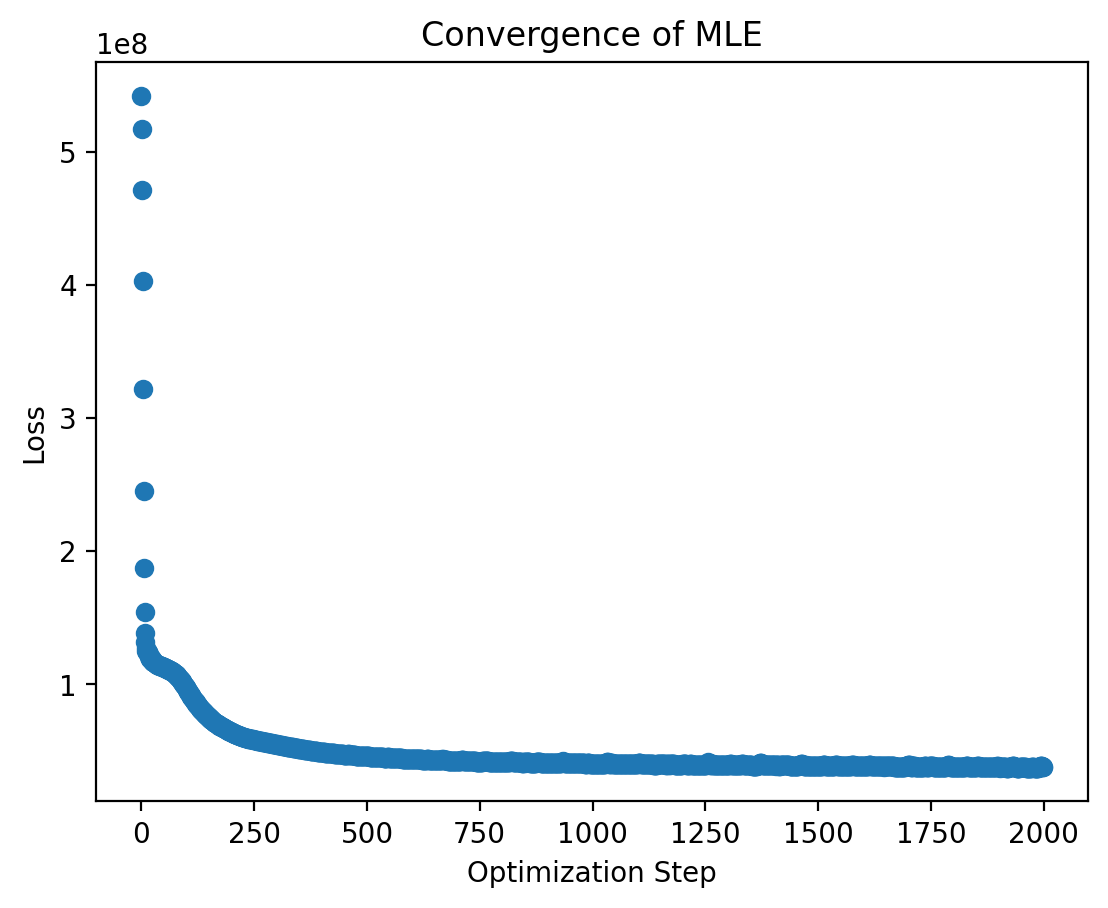

In [42]:
NUM_ITERATIONS = 2000

# Define an optimizer; here we chose the "Adam" algorithm
optimizer = numpyro.optim.Adam(step_size=0.01)

# Pick a random generator seed for the optimizer
key_optimizer = jrandom.PRNGKey(seed=0)

result = cs349_mle_continuous_lvm(
    microscope_generative_model, 
    optimizer, 
    key_optimizer, 
    NUM_ITERATIONS,
    len(data), 
    data,
)

plt.scatter(jnp.arange(NUM_ITERATIONS), result.losses)
plt.xlabel('Optimization Step')
plt.ylabel('Loss')
plt.title('Convergence of MLE')
plt.show()

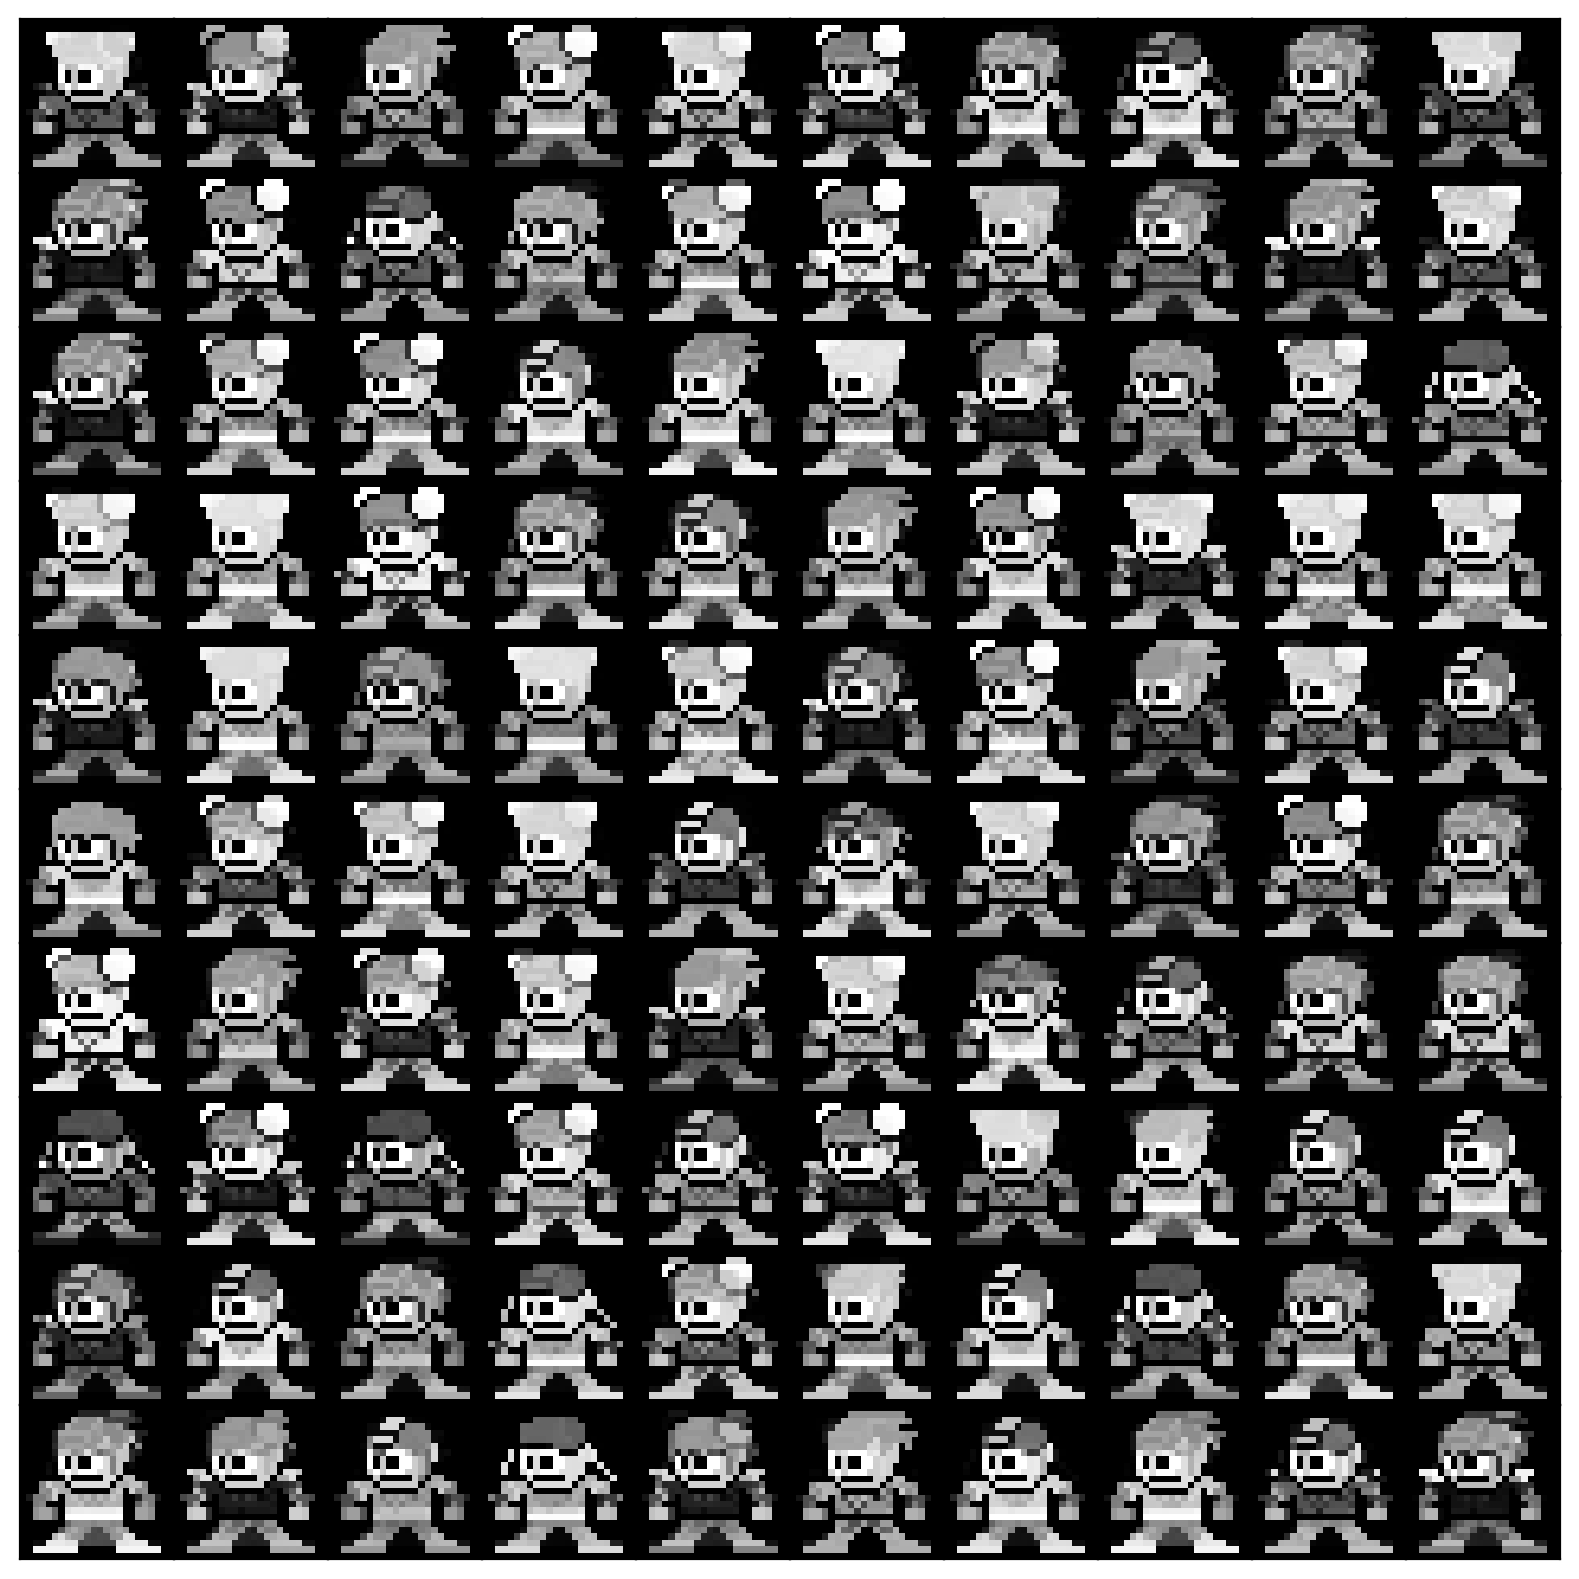

In [43]:
S = 100
generated = cs349_sample_generative_process(
    result.model_mle, jrandom.PRNGKey(seed=0), N=S, 
)

visualize_microscope_samples(generated['mu'])

In [44]:
#z1 = generated['z'][0]
#z2 = generated['z'][1]

z1 = jnp.ones(generated['z'][0].shape) * -3.0
z2 = jnp.ones(generated['z'][0].shape) * 3.0

rho = jnp.linspace(0.0, 1.0, 100)[..., None]
z = z1[None, ...] * rho + z2[None, ...] * (1.0 - rho)

path = cs349_sample_generative_process(
    H.condition(result.model_mle, data=dict(z=z)), 
    jrandom.PRNGKey(seed=0), 
    N=z.shape[0], 
)['mu']

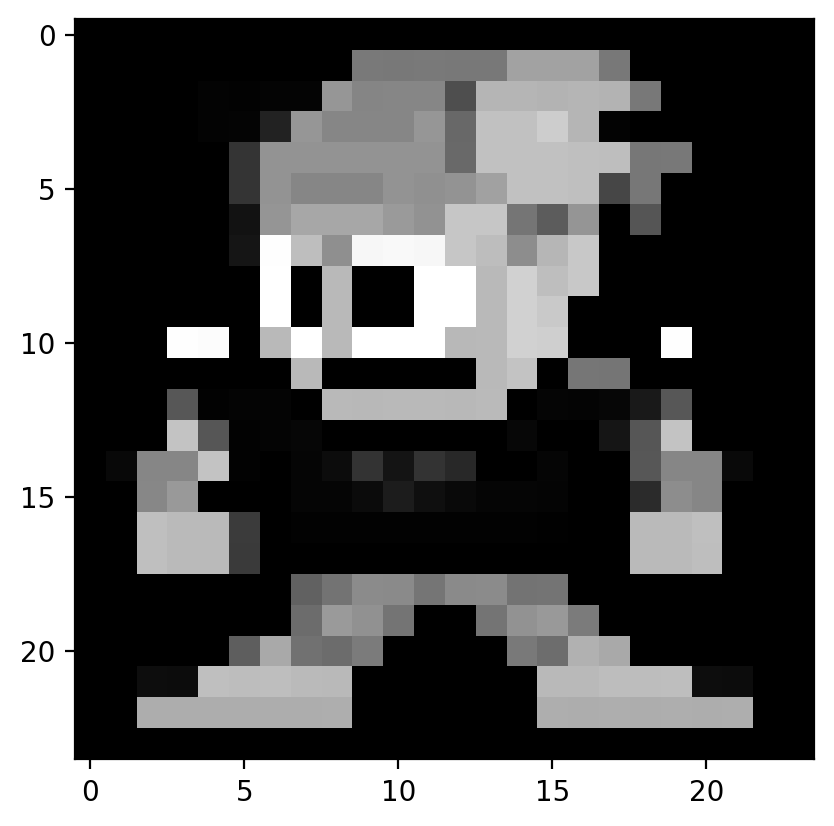

In [45]:
import matplotlib.animation
from IPython.display import HTML

def animate_latent_space_path(path):    
    fig, ax = plt.subplots()
    
    def animate(i):
        ax.imshow(path[i].reshape(24, 24), cmap='gray', vmin=0.0, vmax=1.0)
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(path))        
    return HTML(ani.to_jshtml())


animate_latent_space_path(path)